#  Random Forest- Assignment - Fraud Dataset


In [1]:
!pip install scikit-learn


In [2]:
# Importing the required libraries for the dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from scipy import stats
from collections import Counter
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,classification_report
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importing the dataset

fraud=pd.read_csv("Fraud_check (1).csv")

In [4]:
fraud

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [5]:
fraud.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [6]:
fraud.tail()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO
599,NO,Divorced,96519,158137,16,NO


In [7]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.3+ KB


In [8]:
fraud.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


In [9]:
fraud.size

3600

In [10]:
fraud.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [11]:
fraud.shape

(600, 6)

In [12]:
fraud[fraud.duplicated()].shape

(0, 6)

# Feature Engineering 

In [13]:
# Lets assume: taxable_income <= 30000 as “Risky=0” and others are “Good=1”

fraud["Taxable.Income"].describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Taxable.Income, dtype: float64

In [14]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"

fraud1=fraud.copy()
fraud1["Taxable.Category"]=pd.cut(x=fraud["Taxable.Income"],bins=[10002,30000,99620],labels=["Risky","Good"])
fraud1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Taxable.Category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


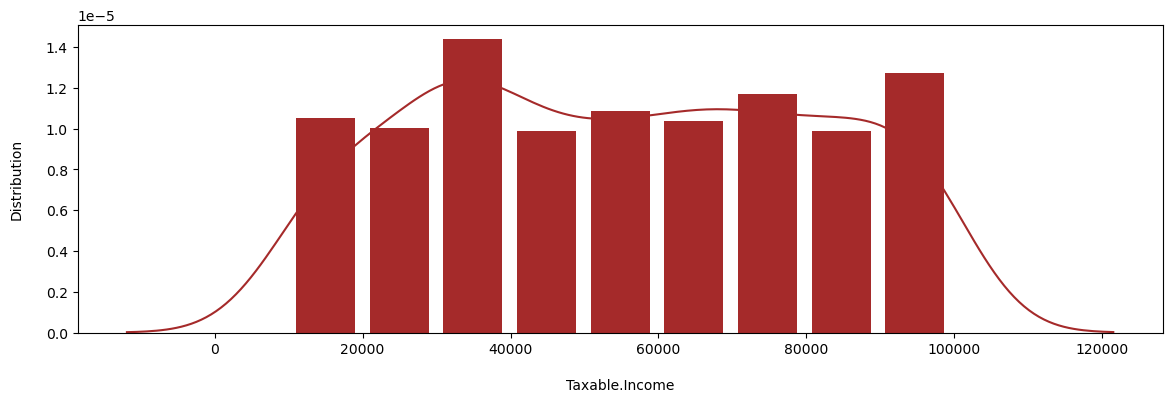

In [15]:
def distplot(param):
    plt.figure(figsize=(14,4))
    sns.distplot(fraud[param],color="brown",hist_kws={"rwidth":0.80,"alpha":1.0})
    plt.xlabel("\n"+param)
    plt.ylabel("Distribution\n")
    plt.show()
distplot("Taxable.Income")

In [16]:
fraud1["Taxable.Category"].value_counts()


Taxable.Category
Good     476
Risky    124
Name: count, dtype: int64

In [17]:
fraud1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Undergrad         600 non-null    object  
 1   Marital.Status    600 non-null    object  
 2   Taxable.Income    600 non-null    int64   
 3   City.Population   600 non-null    int64   
 4   Work.Experience   600 non-null    int64   
 5   Urban             600 non-null    object  
 6   Taxable.Category  600 non-null    category
dtypes: category(1), int64(3), object(3)
memory usage: 29.0+ KB


In [18]:
categorical_features=fraud1.describe(include=["object"]).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')

In [19]:
numerical_features=fraud1.describe(include=["int64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

#  Exploratory Data Analysis
# Univariate plots

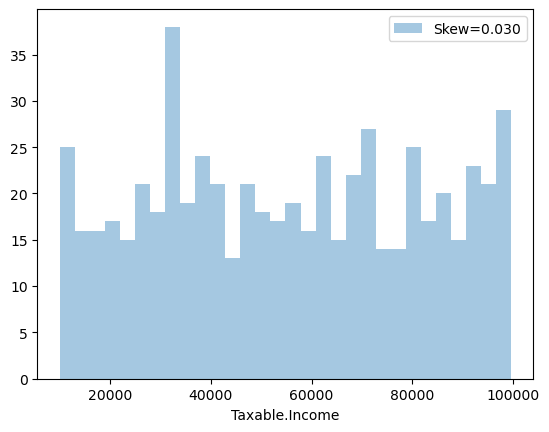

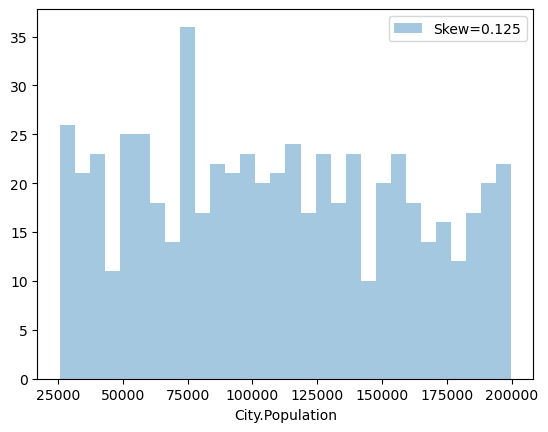

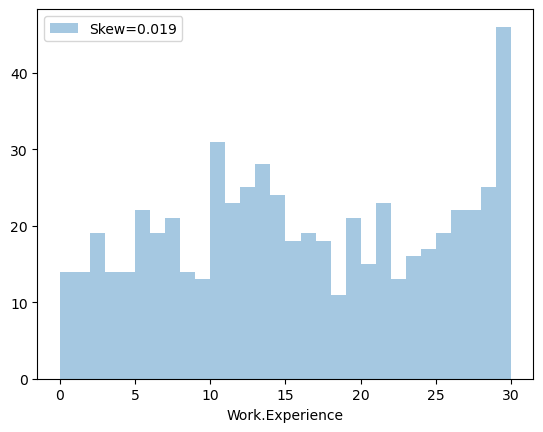

In [20]:
numerical_features=[feature for feature in fraud.columns if fraud[feature].dtypes!="O"]
for feat in numerical_features:
    skew=fraud[feat].skew()
    sns.distplot(fraud[feat],kde=False,label="Skew=%.3f" %(skew),bins=30)
    plt.legend(loc="best")
    plt.show()

# Outliers

In [21]:
numerical_features

['Taxable.Income', 'City.Population', 'Work.Experience']

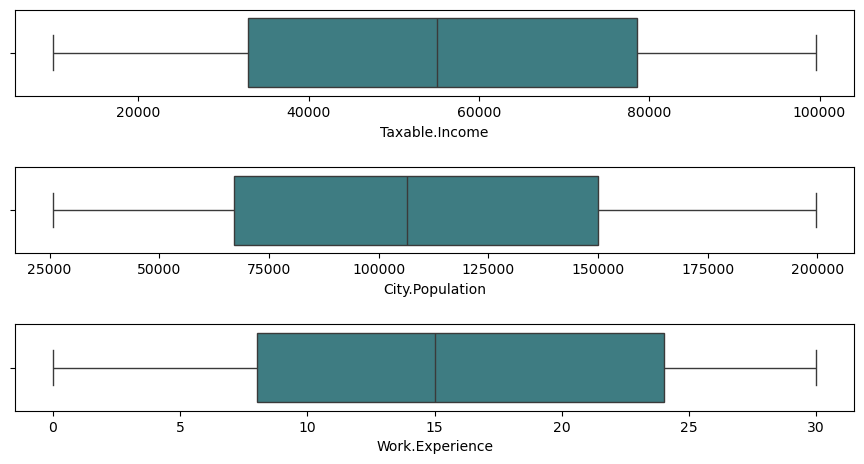

In [22]:
outlier = fraud.copy()
fig,axes=plt.subplots(3,1,figsize=(9,5),sharex=False,sharey=False)
sns.boxplot(x="Taxable.Income",data=outlier,palette="crest",ax=axes[0])
sns.boxplot(x="City.Population",data=outlier,palette="crest",ax=axes[1])
sns.boxplot(x="Work.Experience",data=outlier,palette="crest",ax=axes[2])
plt.tight_layout(pad=2.0)

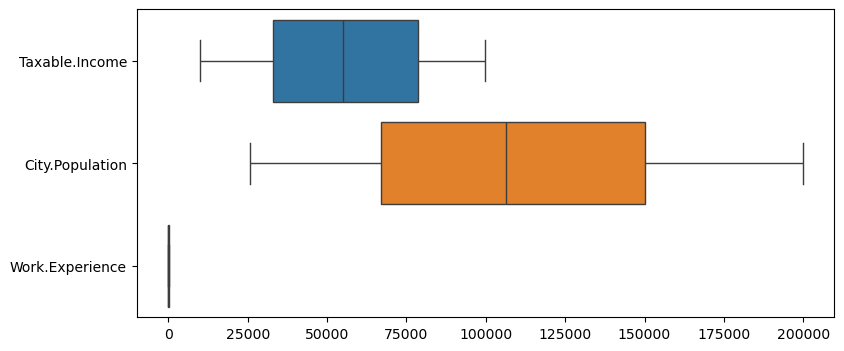

In [23]:
plt.figure(figsize=(9,4))
sns.boxplot(data=fraud[numerical_features],orient="h")
plt.show()

# Multivariate Analysis


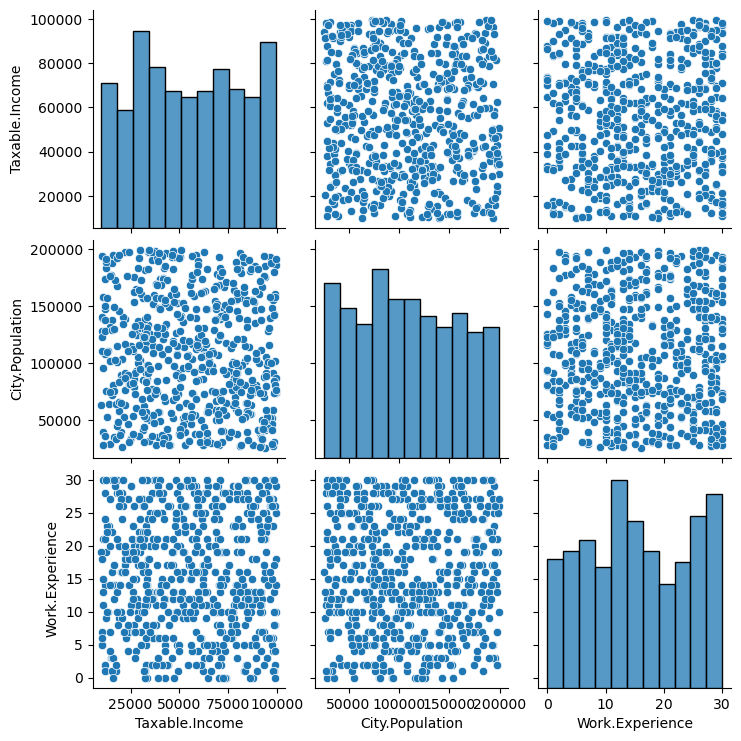

In [24]:
# Pairplot

sns.pairplot(fraud,palette="coolwarm")
plt.show()

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')


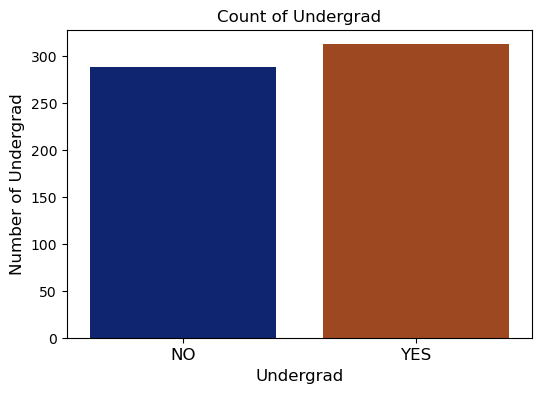

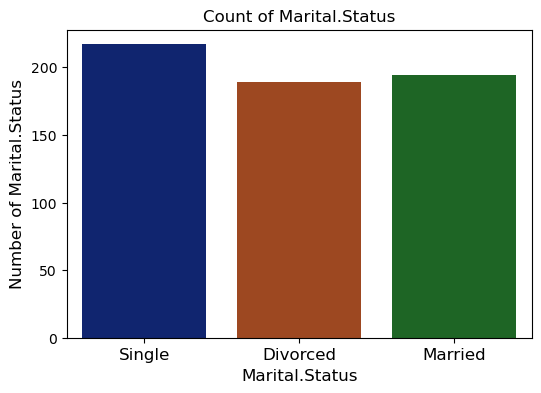

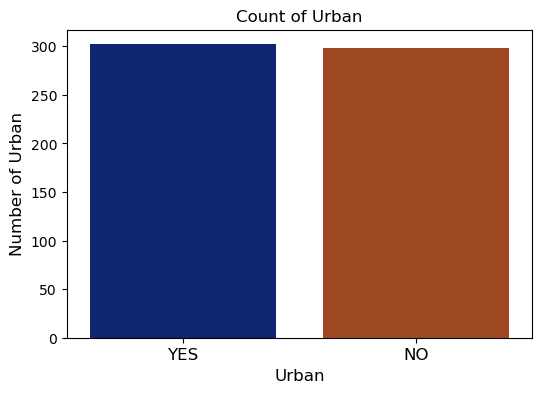

In [25]:
# Countplot

print(categorical_features)

for idx,column in enumerate(categorical_features):
    plt.figure(figsize=(6,4))
    unique=fraud[column].value_counts(ascending=True);
    
    plt.title("Count of " + column)
    sns.countplot(data=fraud1,x=column,palette="dark")
    plt.xticks(rotation=0,size=12)
    
    plt.xlabel(column,fontsize=12)
    plt.ylabel("Number of "+ column,fontsize=12)

In [26]:
!pip install seaborn --upgrade 


In [27]:
# Factorplot

def catplot(param):
    sns.catplot(x= param, size= 6, aspect= 5, data= fraud, y= "Taxable.Income", palette= "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Taxable Income\n")
    plt.show()

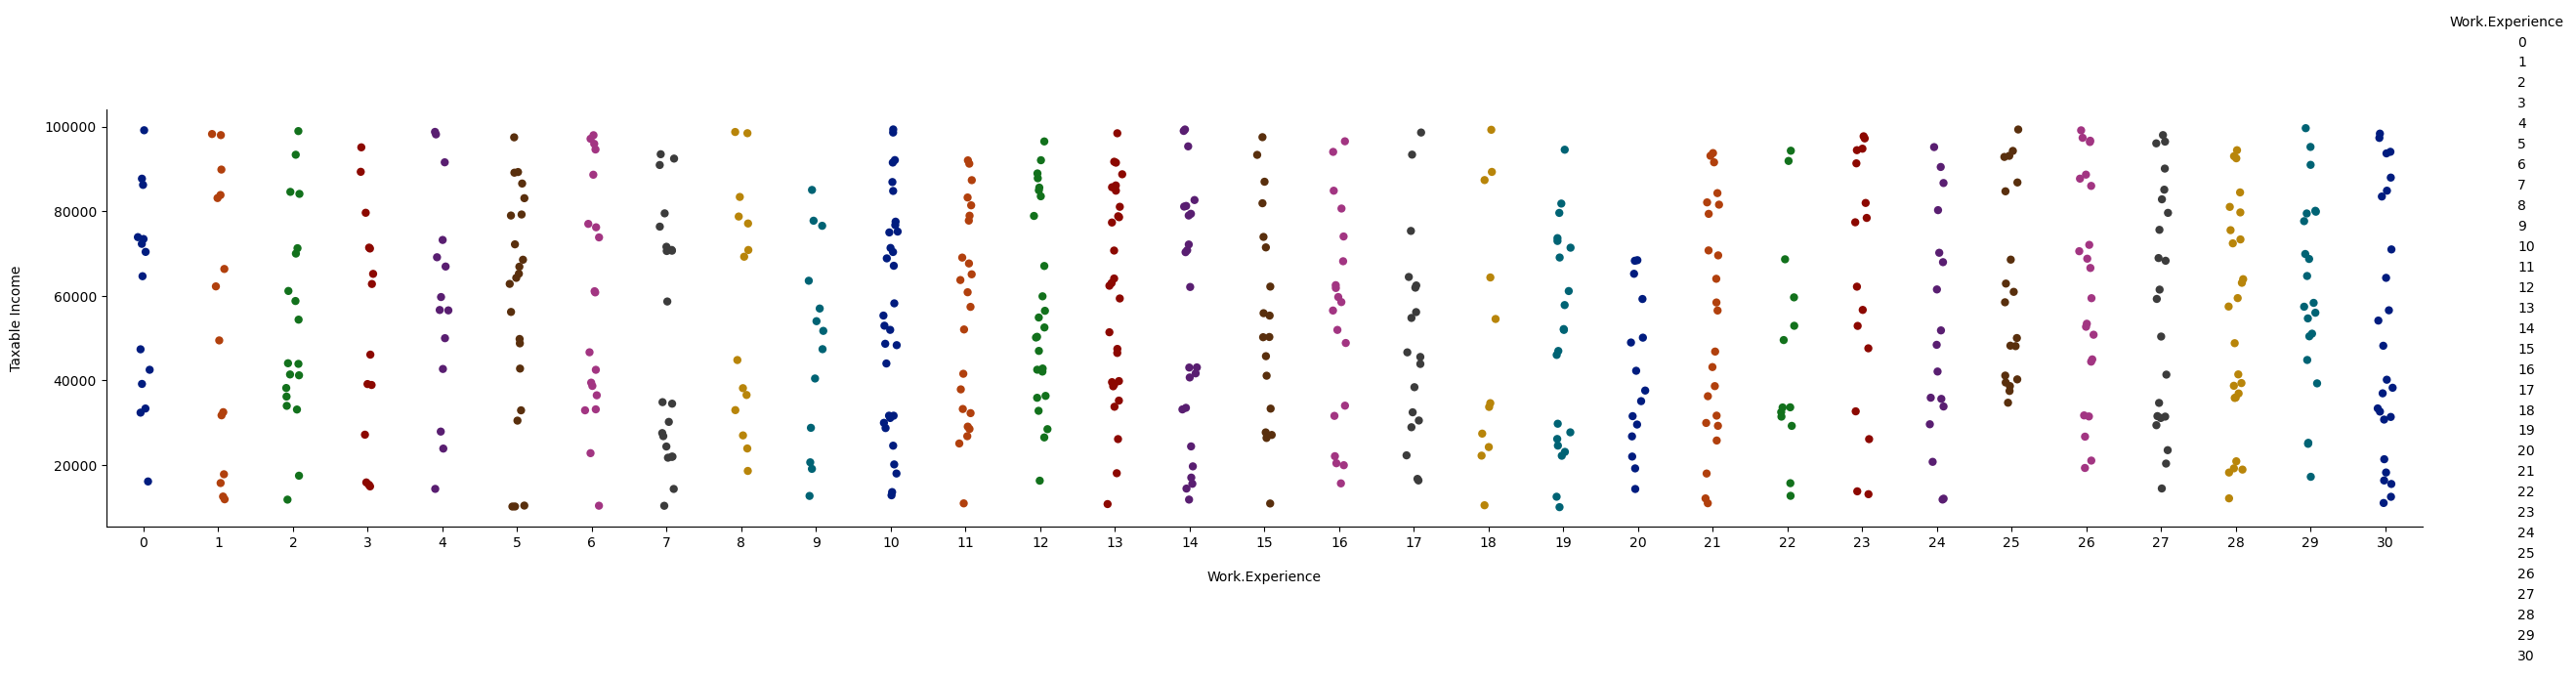

In [28]:
catplot("Work.Experience")


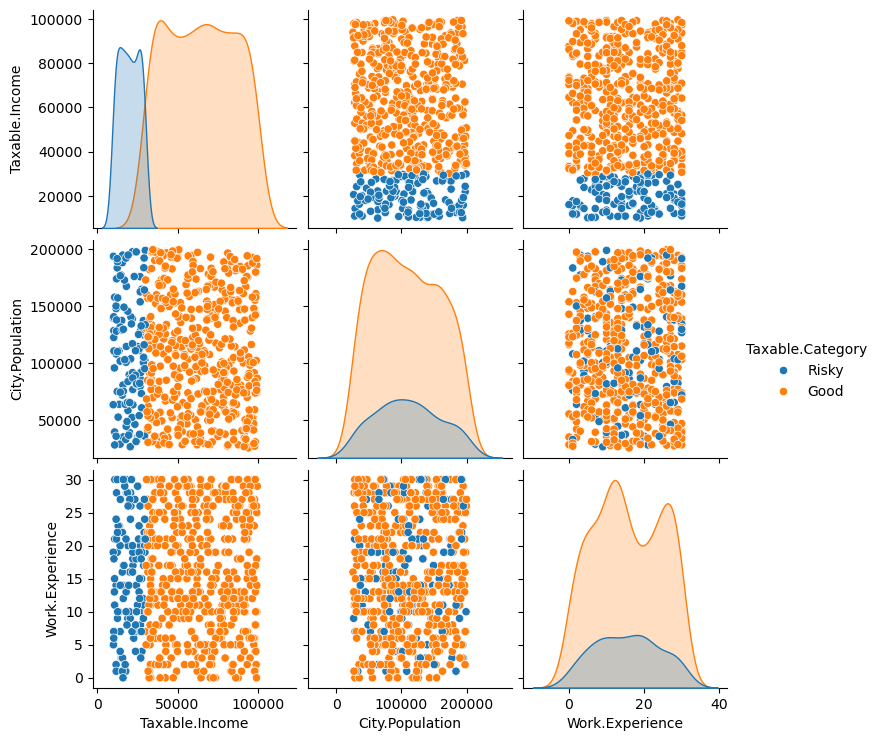

In [29]:
# Pairplot

sns.pairplot(data=fraud1,hue="Taxable.Category")
plt.show()

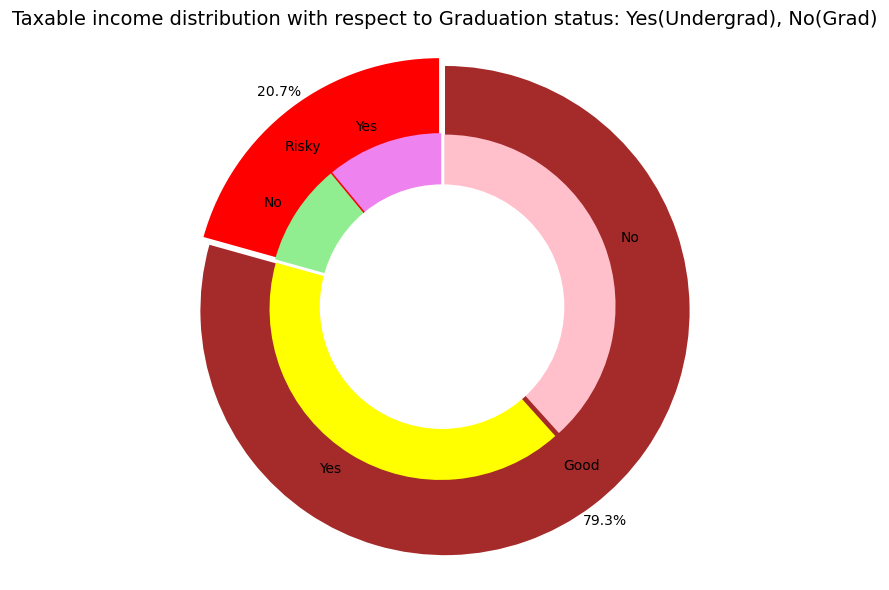

In [30]:
plt.figure(figsize=(9,6))
labels=["Risky","Good"]
values=[fraud1["Taxable.Category"][fraud1["Taxable.Category"]=="Risky"].groupby(by=fraud1.Undergrad).count().sum(),
       fraud1["Taxable.Category"][fraud1["Taxable.Category"]=="Good"].groupby(by=fraud1.Undergrad).count().sum()]
labels_gender=["Yes","No","Yes","No"]
sizes_gender=[66,58,246,230]
colors=["red","brown"]
colors_gender=["violet","lightgreen","yellow","pink"]
explode=(0.2,0.2)
explode_gender=(0.1,0.1,0.1,0.1)
testprops={"fontsize":15,"rotation":"40"}

#plot
plt.pie(values,labels=labels,autopct="%1.1f%%",pctdistance=1.08,labeldistance=0.8,colors=colors,startangle=90,frame=True,explode=explode,radius=10,counterclock=True,)
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90,explode=explode_gender,radius=7,counterclock=True,)

# Draw Circle
centre_circle=plt.Circle((0,0),5,color="black",fc="white",linewidth=0)
fig=plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Taxable income distribution with respect to Graduation status: Yes(Undergrad), No(Grad)', fontsize= 14)

plt.axis("equal")
plt.tight_layout()
plt.show()



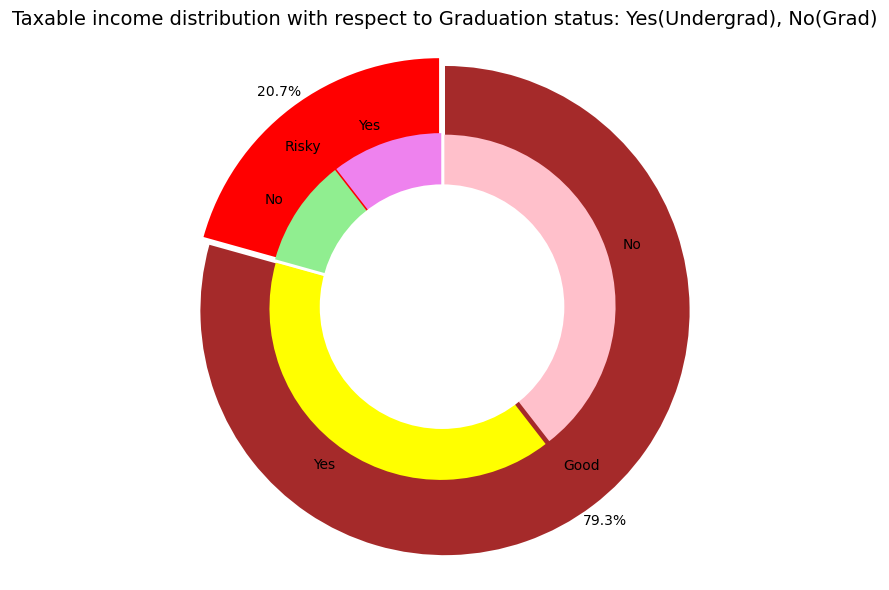

In [31]:
plt.figure(figsize=(9,6))
labels=["Risky","Good"]
values=[fraud1["Taxable.Category"][fraud1["Taxable.Category"]=="Risky"].groupby(by=fraud1["Urban"]).count().sum(),
       fraud1["Taxable.Category"][fraud1["Taxable.Category"]=="Good"].groupby(by=fraud1["Urban"]).count().sum()]
labels_gender=["Yes","No","Yes","No"]
sizes_gender=[63,61,239,237]
colors=["red","brown"]
colors_gender=["violet","lightgreen","yellow","pink"]
explode=(0.2,0.2)
explode_gender=(0.1,0.1,0.1,0.1)
testprops={"fontsize":15,"rotation":"40"}

#plot
plt.pie(values,labels=labels,autopct="%1.1f%%",pctdistance=1.08,labeldistance=0.8,colors=colors,startangle=90,frame=True,explode=explode,radius=10,counterclock=True,)
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90,explode=explode_gender,radius=7,counterclock=True,)

# Draw Circle
centre_circle=plt.Circle((0,0),5,color="black",fc="white",linewidth=0)
fig=plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Taxable income distribution with respect to Graduation status: Yes(Undergrad), No(Grad)', fontsize= 14)

plt.axis("equal")
plt.tight_layout()
plt.show()


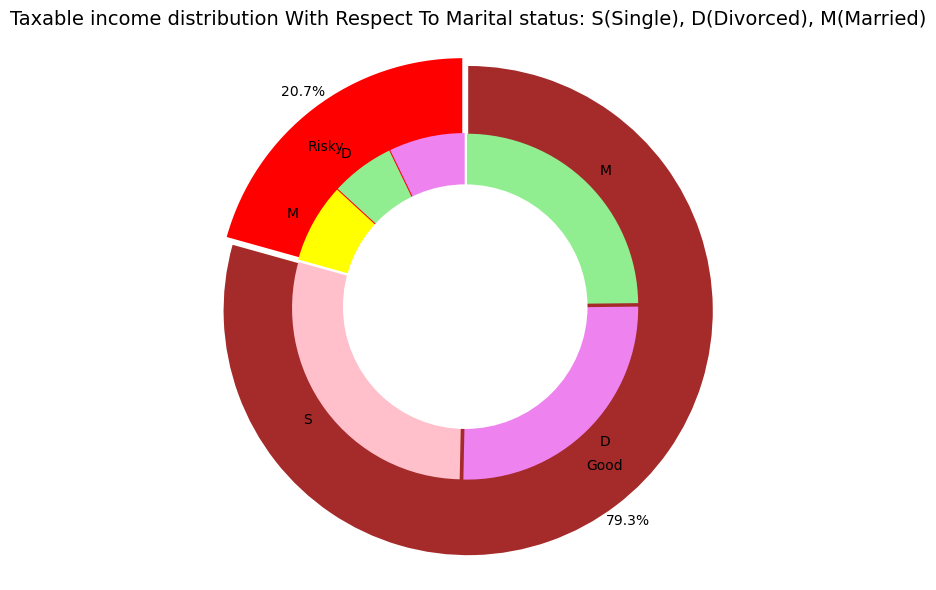

In [32]:
plt.figure(figsize=(9,6))
labels =["Risky", "Good"]
values = [fraud1["Taxable.Category"][fraud1["Taxable.Category"] == 'Risky'].groupby(by = fraud1["Marital.Status"]).count().sum(),
         fraud1["Taxable.Category"][fraud1["Taxable.Category"] == 'Good'].groupby(by = fraud1["Marital.Status"]).count().sum()]
labels_gender = ["","D","M","S","D", "M"]
sizes_gender = [43,36,45,174,153,149]
colors = ["red","brown"]
colors_gender = ["violet","lightgreen","yellow","pink"]
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':40}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10,counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7,counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution With Respect To Marital status: S(Single), D(Divorced), M(Married)', fontsize=14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

In [33]:
fraud_dummy = fraud1.copy()
fraud_dummy.drop(['Taxable.Income'],axis=1, inplace =True)
fraud_dummy = pd.get_dummies(fraud_dummy.iloc[:,:-1])
fraud_dummy.head()


,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,True,False,False,False,True,False,True
1,134075,18,False,True,True,False,False,False,True
2,160205,30,True,False,False,True,False,False,True
3,193264,15,False,True,False,False,True,False,True
4,27533,28,True,False,False,True,False,True,False


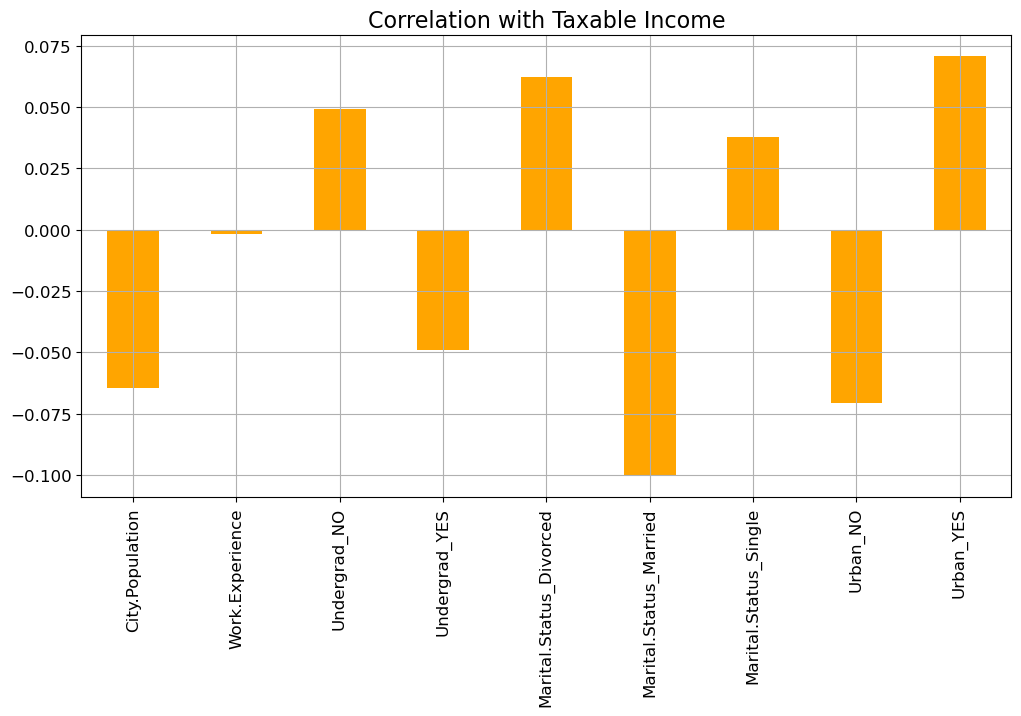

In [34]:

fraud2=fraud_dummy.copy()

correlations=fraud2.corrwith(fraud1["Taxable.Income"])
correlations=correlations[correlations!=1]
positive_correlations=correlations[correlations>0].sort_values(ascending=False)
negative_correlations=correlations[correlations<0].sort_values(ascending=False)

correlations.plot.bar(figsize=(12,6),fontsize=12,color="orange",rot=90,grid=True)
plt.title("Correlation with Taxable Income",fontsize="16")
plt.show()

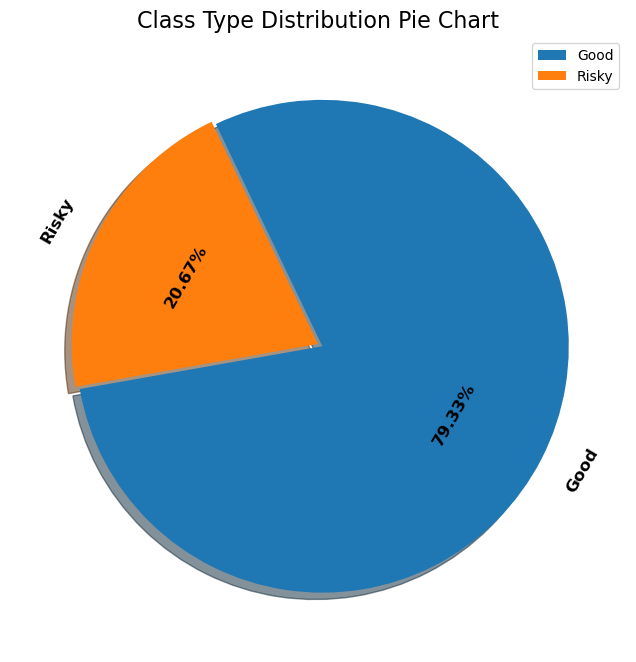

In [35]:
# Checking for Imbalanced or balanced dataset with regards to the Target

plt.figure(figsize=(9,8))
plt.pie(fraud1["Taxable.Category"].value_counts(),labels=fraud1["Taxable.Category"].unique(),
       explode=[0.02,0.0],autopct="%.2f%%",shadow=True,startangle=190,
              textprops = {'size':'large', 'fontweight':'bold', 'rotation': 60, 'color':'black'})
plt.legend(loc="upper right")
plt.title("Class Type Distribution Pie Chart", fontsize = 16)
plt.show()

In [36]:
count_No_termdeposit=len(fraud1[fraud1["Taxable.Category"]=="Good"])
count_Have_termdeposit=len(fraud1[fraud1["Taxable.Category"]=="Risky"])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((count_No_termdeposit / (len(fraud1["Taxable.Category"]))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((count_Have_termdeposit / (len(fraud1["Taxable.Category"]))*100)))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 20.67%


In [37]:
fraud1["Taxable.Category"].value_counts()

Taxable.Category
Good     476
Risky    124
Name: count, dtype: int64

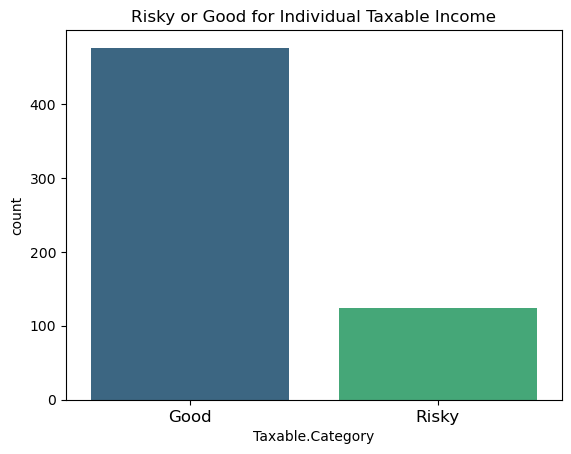

In [38]:
sns.countplot(x="Taxable.Category",data=fraud1,palette="viridis",
             order=fraud1["Taxable.Category"].value_counts().index)
plt.xticks(fontsize=12)
plt.title("Risky or Good for Individual Taxable Income")
plt.show()

# Data Pre-Processing


In [39]:
#Feature Selection Technique

fraud1.columns

Index(['Undergrad', 'Marital.Status', 'Taxable.Income', 'City.Population',
       'Work.Experience', 'Urban', 'Taxable.Category'],
      dtype='object')

In [40]:

fraud3=fraud1.copy()
fraud3.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','City.Population':'City_Population','Work.Experience':'Work_Experience','Taxable.Category':'Taxable_Category'},inplace=True)
fraud3.drop("Taxable_Income",axis=1,inplace=True)
categorical_features=fraud3.describe(include=["object","category"]).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'Taxable_Category'], dtype='object')

#  Label Encoding

In [41]:
fraud3.columns

Index(['Undergrad', 'Marital_Status', 'City_Population', 'Work_Experience',
       'Urban', 'Taxable_Category'],
      dtype='object')

In [42]:
le=LabelEncoder()
for col in categorical_features:
    le.fit(fraud3[col])
    fraud3[col]=le.transform(fraud3[col])
fraud3.head()

,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,Taxable_Category
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


#  Feature Selection Technique


In [43]:
fraud4=fraud1.copy()
fraud4.drop("Taxable.Income",axis=1,inplace=True)
fraud4=pd.get_dummies(fraud4.iloc[:,:-1])
fraud4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,True,False,False,False,True,False,True
1,134075,18,False,True,True,False,False,False,True
2,160205,30,True,False,False,True,False,False,True
3,193264,15,False,True,False,False,True,False,True
4,27533,28,True,False,False,True,False,True,False


In [44]:

fraud4["Taxable_Income"]=fraud1["Taxable.Category"]
fraud4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,True,False,False,False,True,False,True,Good
1,134075,18,False,True,True,False,False,False,True,Good
2,160205,30,True,False,False,True,False,False,True,Good
3,193264,15,False,True,False,False,True,False,True,Good
4,27533,28,True,False,False,True,False,True,False,Good


In [45]:

le=LabelEncoder()
le.fit(fraud4["Taxable_Income"])
fraud4["Taxable_Income"]=le.transform(fraud4["Taxable_Income"])
fraud4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,True,False,False,False,True,False,True,0
1,134075,18,False,True,True,False,False,False,True,0
2,160205,30,True,False,False,True,False,False,True,0
3,193264,15,False,True,False,False,True,False,True,0
4,27533,28,True,False,False,True,False,True,False,0


In [46]:
le=LabelEncoder()
le.fit(fraud4["Undergrad_NO"])
fraud4["Undergrad_NO"]=le.transform(fraud4["Undergrad_NO"])
fraud4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,False,False,False,True,False,True,0
1,134075,18,0,True,True,False,False,False,True,0
2,160205,30,1,False,False,True,False,False,True,0
3,193264,15,0,True,False,False,True,False,True,0
4,27533,28,1,False,False,True,False,True,False,0


In [47]:
le=LabelEncoder()
le.fit(fraud4["Undergrad_YES"])
fraud4["Undergrad_YES"]=le.transform(fraud4["Undergrad_YES"])
fraud4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,False,False,True,False,True,0
1,134075,18,0,1,True,False,False,False,True,0
2,160205,30,1,0,False,True,False,False,True,0
3,193264,15,0,1,False,False,True,False,True,0
4,27533,28,1,0,False,True,False,True,False,0


In [48]:
le=LabelEncoder()
le.fit(fraud4["Marital.Status_Divorced"])
fraud4["Marital.Status_Divorced"]=le.transform(fraud4["Marital.Status_Divorced"])
fraud4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,False,True,False,True,0
1,134075,18,0,1,1,False,False,False,True,0
2,160205,30,1,0,0,True,False,False,True,0
3,193264,15,0,1,0,False,True,False,True,0
4,27533,28,1,0,0,True,False,True,False,0


In [49]:
le=LabelEncoder()
le.fit(fraud4["Marital.Status_Married"])
fraud4["Marital.Status_Married"]=le.transform(fraud4["Marital.Status_Married"])
fraud4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,True,False,True,0
1,134075,18,0,1,1,0,False,False,True,0
2,160205,30,1,0,0,1,False,False,True,0
3,193264,15,0,1,0,0,True,False,True,0
4,27533,28,1,0,0,1,False,True,False,0


In [50]:
le=LabelEncoder()
le.fit(fraud4["Marital.Status_Single"])
fraud4["Marital.Status_Single"]=le.transform(fraud4["Marital.Status_Single"])
fraud4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,False,True,0
1,134075,18,0,1,1,0,0,False,True,0
2,160205,30,1,0,0,1,0,False,True,0
3,193264,15,0,1,0,0,1,False,True,0
4,27533,28,1,0,0,1,0,True,False,0


In [51]:
le=LabelEncoder()
le.fit(fraud4["Urban_NO"])
fraud4["Urban_NO"]=le.transform(fraud4["Urban_NO"])
fraud4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,True,0
1,134075,18,0,1,1,0,0,0,True,0
2,160205,30,1,0,0,1,0,0,True,0
3,193264,15,0,1,0,0,1,0,True,0
4,27533,28,1,0,0,1,0,1,False,0


In [52]:
le=LabelEncoder()
le.fit(fraud4["Urban_YES"])
fraud4["Urban_YES"]=le.transform(fraud4["Urban_YES"])
fraud4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,0
1,134075,18,0,1,1,0,0,0,1,0
2,160205,30,1,0,0,1,0,0,1,0
3,193264,15,0,1,0,0,1,0,1,0
4,27533,28,1,0,0,1,0,1,0,0


In [53]:
# Splitting the (x-independent) & (y-dependent variable)

x=fraud4.iloc[:,:-1]
y=fraud4.Taxable_Income

In [54]:
# Feature Extraction

test=SelectKBest(score_func=chi2,k=4)
fit=test.fit(x,y)

In [55]:
# Summarize the scores

scores=fit.scores_
features=fit.transform(x)

In [56]:
score_fraud=pd.DataFrame(list(zip(x.columns,scores)),columns=["Feature","Score"])
score_fraud.sort_values(by="Score",ascending=False,inplace=True)
score_fraud

,Feature,Score
0,City.Population,2045.643886
5,Marital.Status_Married,0.756912
4,Marital.Status_Divorced,0.302172
6,Marital.Status_Single,0.095850
2,Undergrad_NO,0.048929
3,Undergrad_YES,0.045165
1,Work.Experience,0.011709
7,Urban_NO,0.007044
8,Urban_YES,0.006951


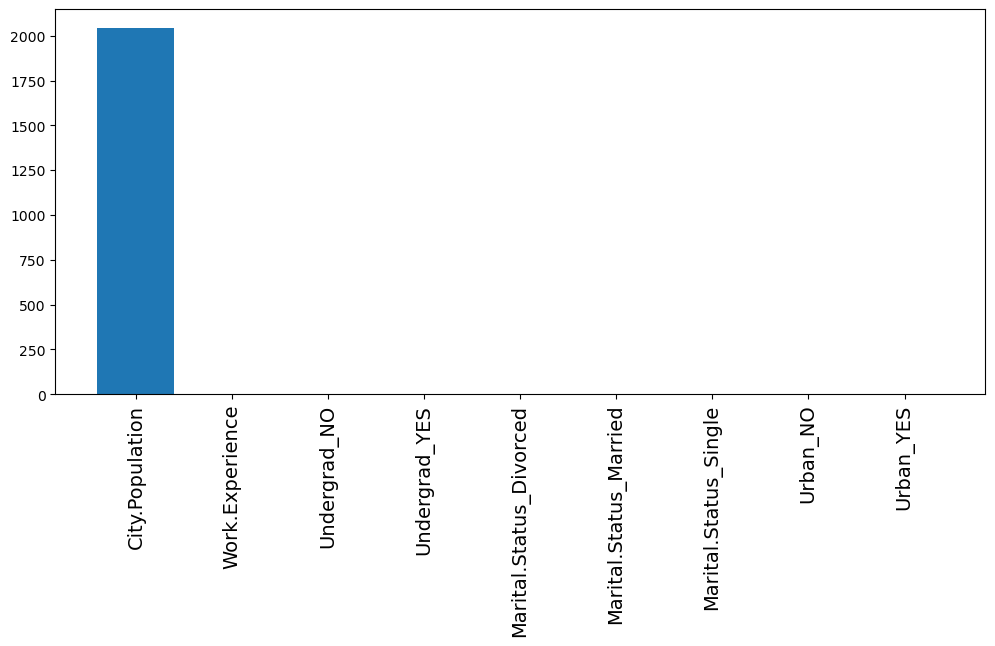

In [57]:

fig,axes=plt.subplots(figsize=(12,5))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation=90,size=14)
plt.show()

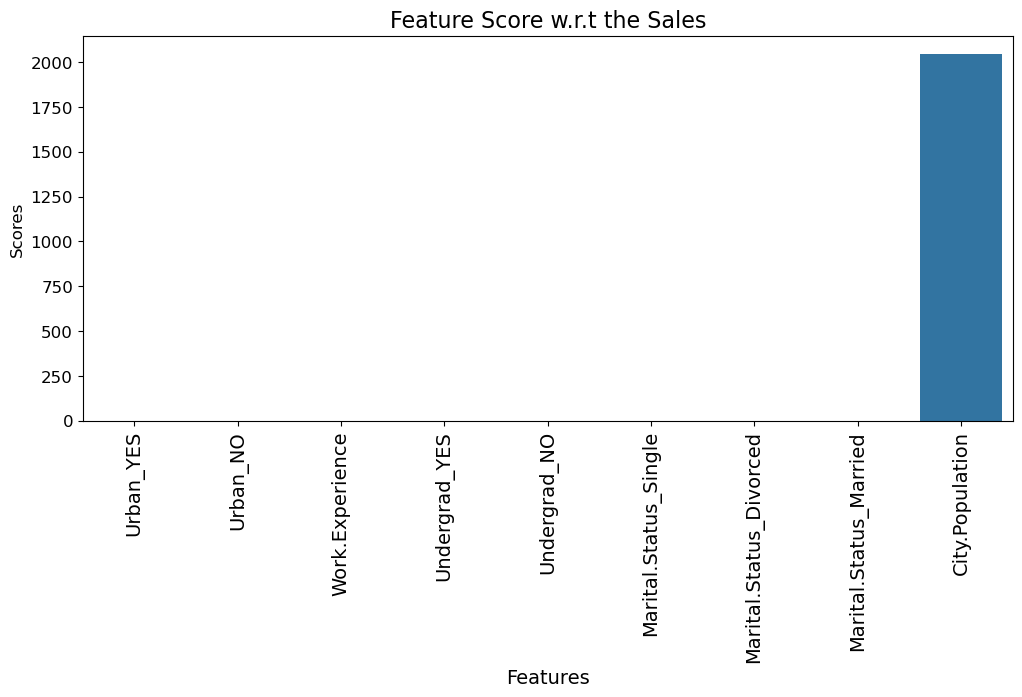

In [58]:
plt.figure(figsize=(12,5))
sns.barplot(x='Feature', y="Score", data=score_fraud, order=score_fraud.sort_values('Score').Feature)
plt.xlabel("Features", size=14)
plt.ylabel("Scores", size=12)
plt.yticks(rotation = 0, fontsize = 12)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Score w.r.t the Sales", size=16)
plt.show()


In [59]:
# Random Forest Built-in Feature Importance

rf_classifier=RandomForestClassifier(random_state=42,n_jobs=-1,max_depth=5,n_estimators=100,oob_score=True)
rf_classifier.fit(x,y)

rf=RandomForestClassifier(random_state=42,n_jobs=-1)
params={"max_depth": [2,3,5,10,20],"min_samples_leaf":[5,10,20,50,100,200],"n_estimators":[10,25,30,50,100,200]}

grid_search = GridSearchCV(estimator= rf, param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(x,y)
rf_best=grid_search.best_estimator_

print('Checking the oob score :', rf_classifier.oob_score_)
print('Best Score             :', grid_search.best_score_)
print('RF Best Model          :', rf_best)




Fitting 4 folds for each of 180 candidates, totalling 720 fits
Checking the oob score : 0.7933333333333333
Best Score             : 0.7933333333333333
RF Best Model          : RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)


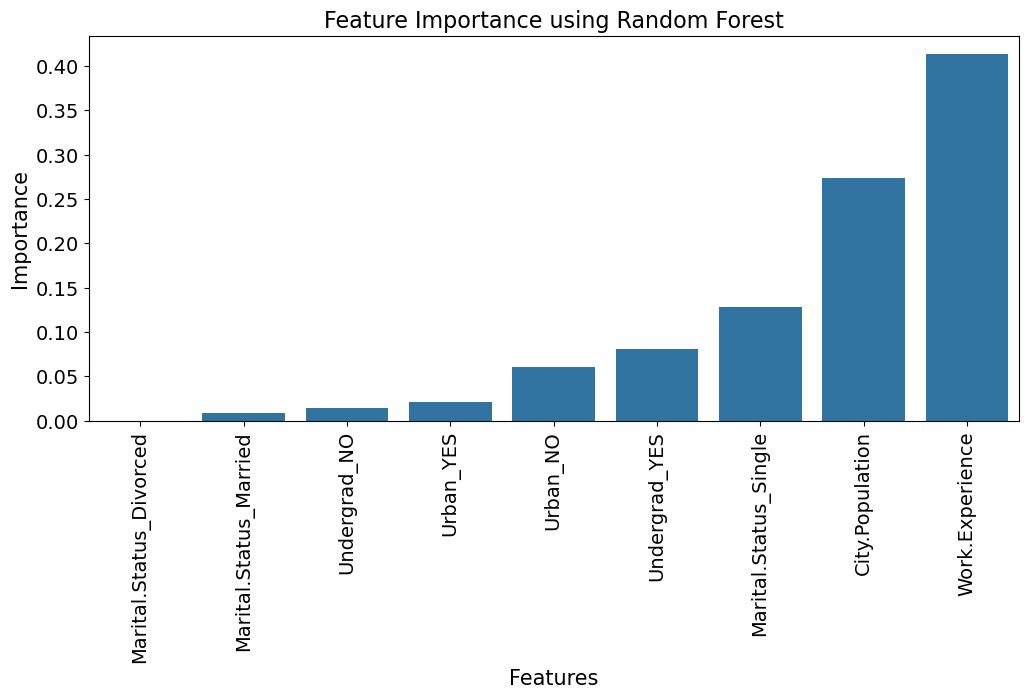

In [60]:
# Now let’s sort the data with the help of feature importance

rf_best.feature_importances_
imp_df = pd.DataFrame({"Feature": x.columns, "Importance": rf_best.feature_importances_})

plt.figure(figsize=(12,5))
sns.barplot(x= 'Feature', y= "Importance", data= imp_df, order= imp_df.sort_values('Importance').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Importance using Random Forest", size=16)
plt.show()



In [61]:
# Test Train Split With Imbalanced Dataset

x=fraud3.drop("Taxable_Category",axis=1)
y=fraud3["Taxable_Category"]

In [62]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)


In [63]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (420, 5)
Shape of x_test  :  (180, 5)
Shape of y_train :  (420,)
Shape of y_test  :  (180,)


In [64]:
# StratifiedKFold

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions

for train_ix,test_ix in skf.split(x,y):
    
    #Select rows
    
    train_x,test_x=x.iloc[train_ix],x.loc[test_ix]
    train_y,test_y=y.iloc[train_ix],y.iloc[test_ix]
    
# Summarize train and test composition

counter_train=Counter(train_y)
counter_test=Counter(test_y)

print('Training Data :',counter_train)
print('Testing Data  :',counter_test)

Training Data : Counter({0: 429, 1: 111})
Testing Data  : Counter({0: 47, 1: 13})


In [65]:
# Grid search using Stratified Kfold Splits on Imbalanced Dataset
        
def print_score(clf,X_train,y_train,X_test,y_test,train=True):
    if train:
        pred=clf.predict(X_train)
        clf_report=pd.DataFrame(classification_report(y_train,pred,output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
    
    elif train==False:
        pred=clf.predict(X_test)
        clf_report=pd.DataFrame(classification_report(y_test,pred,output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [66]:
rf_clf1=RandomForestClassifier(n_estimators=100)
rf_clf1.fit(train_x,train_y)

print_score(rf_clf1,train_x,train_y,test_x,test_y,train=True)
print_score(rf_clf1,train_x,train_y,test_x,test_y,train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    429.0  111.0       1.0      540.0         540.0
_______________________________________________
Confusion Matrix: 
 [[429   0]
 [  0 111]]

Test Result:
Accuracy Score: 75.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.785714   0.250000      0.75   0.517857      0.669643
recall      0.936170   0.076923      0.75   0.506547      0.750000
f1-score    0.854369   0.117647      0.75   0.486008      0.694746
support    47.000000  13.000000      0.75  60.000000     60.000000
_______________________________________________
Confusion Matr

In [67]:
# Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset

rf_clf2=RandomForestClassifier(n_estimators=100)
rf_clf2.fit(x_train,y_train)

print_score(rf_clf2,x_train,y_train,x_test,y_test,train=True)
print_score(rf_clf2,x_train,y_train,x_test,y_test,train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1  accuracy  macro avg  weighted avg
precision    1.0   1.0       1.0        1.0           1.0
recall       1.0   1.0       1.0        1.0           1.0
f1-score     1.0   1.0       1.0        1.0           1.0
support    333.0  87.0       1.0      420.0         420.0
_______________________________________________
Confusion Matrix: 
 [[333   0]
 [  0  87]]

Test Result:
Accuracy Score: 76.11%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.787356   0.0  0.761111    0.393678      0.625511
recall       0.958042   0.0  0.761111    0.479021      0.761111
f1-score     0.864353   0.0  0.761111    0.432177      0.686681
support    143.000000  37.0  0.761111  180.000000    180.000000
_______________________________________________
Confusion Matrix: 
 [[137   6]
 [ 

In [68]:
# Handling imbalance data using SMOTE based techniques

x=fraud3.drop(["Taxable_Category"],axis=1)
y=fraud3["Taxable_Category"]

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=0,stratify=y)


In [69]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (420, 5)
Shape of x_test  :  (180, 5)
Shape of y_train :  (420,)
Shape of y_test  :  (180,)


In [70]:
# SMOTE Oversampling technique

counter=Counter(y_train)
print("Before",counter)
smt=SMOTE()
x_train_sm,y_train_sm=smt.fit_resample(x_train,y_train)

counter=Counter(y_train_sm)
print("After",counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 333})


In [71]:
# ADASYN: Adaptive Synthetic Sampling Approach

counter=Counter(y_train)
print("Before",counter)
ada=ADASYN(random_state=130)
x_train_ada,y_train_ada=ada.fit_resample(x_train,y_train)

counter=Counter(y_train)
print("After",counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 87})


In [72]:
# Hybridization: SMOTE + Tomek Links

counter=Counter(y_train)
print("Before",counter)
smtom=SMOTETomek(random_state=139)
x_train_smtom,y_train_smtom=smtom.fit_resample(x_train,y_train)

counter=Counter(y_train_smtom)
print("After",counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 239, 1: 239})


In [73]:
# Hybridization: SMOTE + ENN

counter=Counter(y_train)
print("Before",counter)
smenn=SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)

counter=Counter(y_train_smenn)
print("After",counter)


Before Counter({0: 333, 1: 87})
After Counter({1: 92, 0: 77})


In [74]:
# Performance Analysis after Resampling

sample_data={"ACTUAL":[x_train,y_train],"SMOTE":[x_train_sm,y_train_sm],"ADASYN":[x_train_ada,y_train_ada],
            "SMOTE_TOMEK":[x_train_smtom,y_train_smtom],"SMOTE_ENN":[x_train_smenn,y_train_smenn]}

In [75]:
def test_eval(clf_model,x_test,y_test,algo=None,sampling=None):
    
    #Test set prediction
    
    y_prob=clf_model.predict_proba(x_test)
    y_pred=clf_model.predict(x_test)
    
    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    
    f1=f1_score(y_test,y_pred,average="micro")
    recall=recall_score(y_test,y_pred,average="micro")
    precision=precision_score(y_test,y_pred,average="micro")
    
    return algo,precision,recall,f1,sampling

In [76]:

model_params={"random_forest":{"model":RandomForestClassifier(),"params":{"n_estimators":[5, 10, 15, 20, 25],
              "max_depth":[i for i in range(5,16,2)],"min_samples_split":[2, 5, 10, 15, 20, 50, 100],
            "min_samples_leaf":[1,2,5],"criterion":["gini","entropy"],"max_features":['log2', 'sqrt', 'auto']}}}

In [77]:
cv = StratifiedKFold (n_splits=5, random_state=100, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resample , data in sample_data.items():
        clf3 = RandomizedSearchCV (model_hp['model'], model_hp['params'], cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf3.fit(data[0], data[1])
        clf_best1 = clf3.best_estimator_
        print('='*60)
        print(model+' with ' + resample)
        print('-'*60)
        output.append(test_eval(clf_best1, x_test, y_test, model, resample))

random_forest with ACTUAL
------------------------------------------------------------
Confusion Matrix
[[140   3]
 [ 37   0]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       143
           1       0.00      0.00      0.00        37

    accuracy                           0.78       180
   macro avg       0.40      0.49      0.44       180
weighted avg       0.63      0.78      0.70       180
 

random_forest with SMOTE
------------------------------------------------------------
Confusion Matrix
[[98 45]
 [23 14]] 

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.69      0.74       143
           1       0.24      0.38      0.29        37

    accuracy                           0.62       180
   macro avg       0.52      0.53      0.52       180
weighted avg       0.69      0.62      0.65       180
 

random_forest with ADASYN
-------------------

In [78]:
# As the results can be compared, ADASYN technique gave the best results we are going to use it further

counter=Counter(y_train)
print("Before",counter)
ada=ADASYN(random_state=130)
x_train_ada,y_train_ada=ada.fit_resample(x_train,y_train)

counter-Counter(y_train)
print("Before",counter)
ada=ADASYN(random_state=130)
x_train_ada,y_train_ada=ada.fit_resample(x_train,y_train)

Before Counter({0: 333, 1: 87})
Before Counter({0: 333, 1: 87})


In [79]:
x_train,x_test,y_train,y_test = train_test_split(x_train_ada,y_train_ada,test_size=0.3,random_state=0, stratify=y_train_ada)

counter = Counter(y_train)
print('Train Counter    : ',counter)
counter = Counter(y_test)
print('Test Counter     : ',counter)
print("Shape of X_train : ",x_train.shape)
print("Shape of X_test  : ", x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Train Counter    :  Counter({0: 233, 1: 229})
Test Counter     :  Counter({0: 100, 1: 98})
Shape of X_train :  (462, 5)
Shape of X_test  :  (198, 5)
Shape of y_train :  (462,)
Shape of y_test  :  (198,)


#  Random Forest

In [80]:
# Random Forest hyperparameter tuning

score_array=[]
for each in range(1,200):
    rf_loop=RandomForestClassifier(n_estimators=each,random_state=10)
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [81]:
loc=np.array(score_array).max()
score_array.index(loc)+1

18

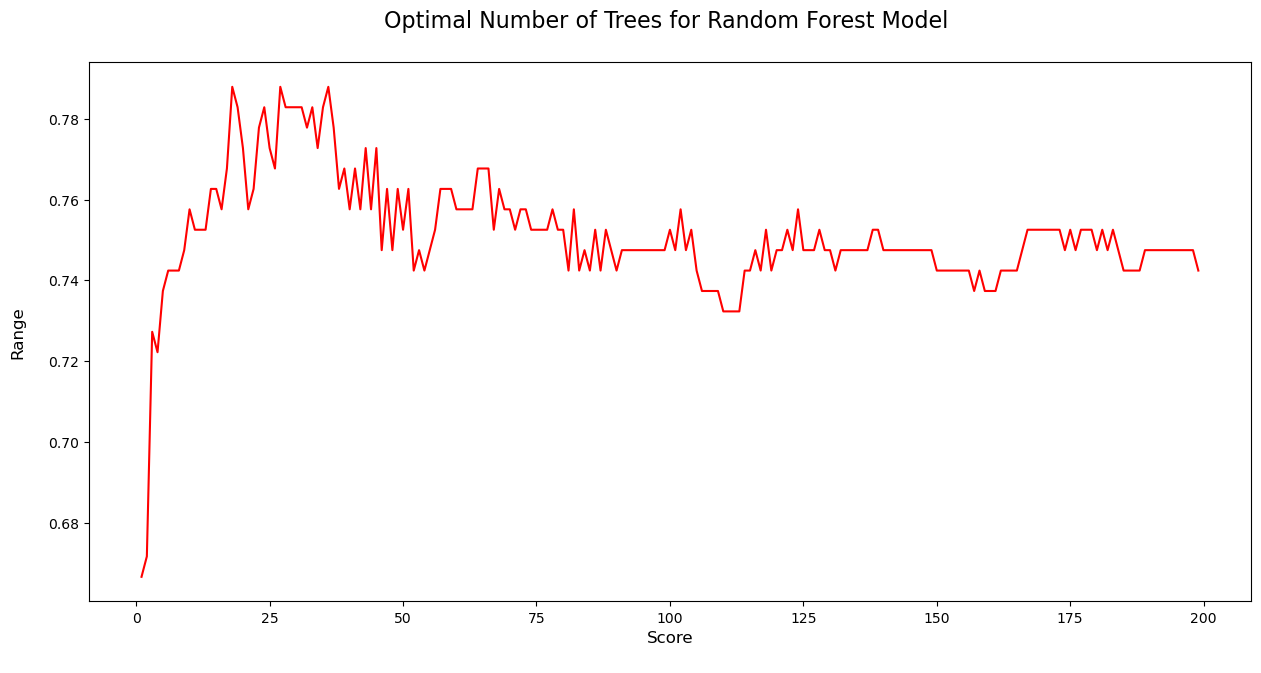

In [82]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = 'r')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontsize = "16")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()



In [83]:
 # Randomized Search Cross Validation
    
n_estimators=[int(x) for x in np.linspace(start=0,stop=200,num=200)]
max_features=["auto","sqrt"]
max_depth=[int(x) for x in np.linspace(10,110,num=11)]
max_depth.append(None)
min_samples_split=[2,5,10]
min_samples_leaf=[1,2,4]
bootstrap=[True,False]

random_grid={"n_estimators":n_estimators,"max_features":max_features,
            "max_depth":max_depth,"min_samples_split":min_samples_split,
            "min_samples_leaf":min_samples_leaf,"bootstrap":bootstrap}
rf_clf=RandomForestClassifier(random_state=42)
rf_cv=RandomizedSearchCV(estimator=rf_clf,scoring="f1",param_distributions=random_grid,n_iter=100,cv=3,
                        verbose=2,random_state=42,n_jobs=-1)

rf_cv.fit(x_train,y_train)
rf_best_params=rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf=RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train,y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True})
Train Result:
Accuracy Score: 94.37%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.968326    0.921162  0.943723    0.944744      0.944948
recall       0.918455    0.969432  0.943723    0.943944      0.943723
f1-score     0.942731    0.944681  0.943723    0.943706      0.943698
support    233.000000  229.000000  0.943723  462.000000    462.000000
_______________________________________________
Confusion Matrix: 
 [[214  19]
 [  7 222]]

Test Result:
Accuracy Score: 73.23%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.737374   0.727273  0.732323    0.732323      0.7323

In [84]:
# Grid Search Cross Validation

pipe_rfc = Pipeline([('scl', StandardScaler()), ('rfc', RandomForestClassifier(random_state=0, n_jobs=-1) )])
param_grid_rfc =  [{'rfc__n_estimators': [100, 200,300,400], 'rfc__max_features':[0.05 , 0.1],
                    'rfc__max_depth': [None, 5], 'rfc__min_samples_split': [0.005, 0.01]}]

kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state= 0)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring='f1', verbose= 1, n_jobs=-1)

start = time()
grid_rfc = grid_rfc.fit(x_train, y_train)
end = time()

print("RFC grid search took %.3f seconds" %(end-start))
print('-------Best score----------')
print(grid_rfc.best_score_ * 100.0)
print('-------Best params----------')
print(grid_rfc.best_params_)


Fitting 10 folds for each of 32 candidates, totalling 320 fits
RFC grid search took 51.776 seconds
-------Best score----------
70.38844506088265
-------Best params----------
{'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.005, 'rfc__n_estimators': 400}


In [85]:

rf_best=rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=60, random_state=42)

In [86]:

fraud1["Taxable.Category"].unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']

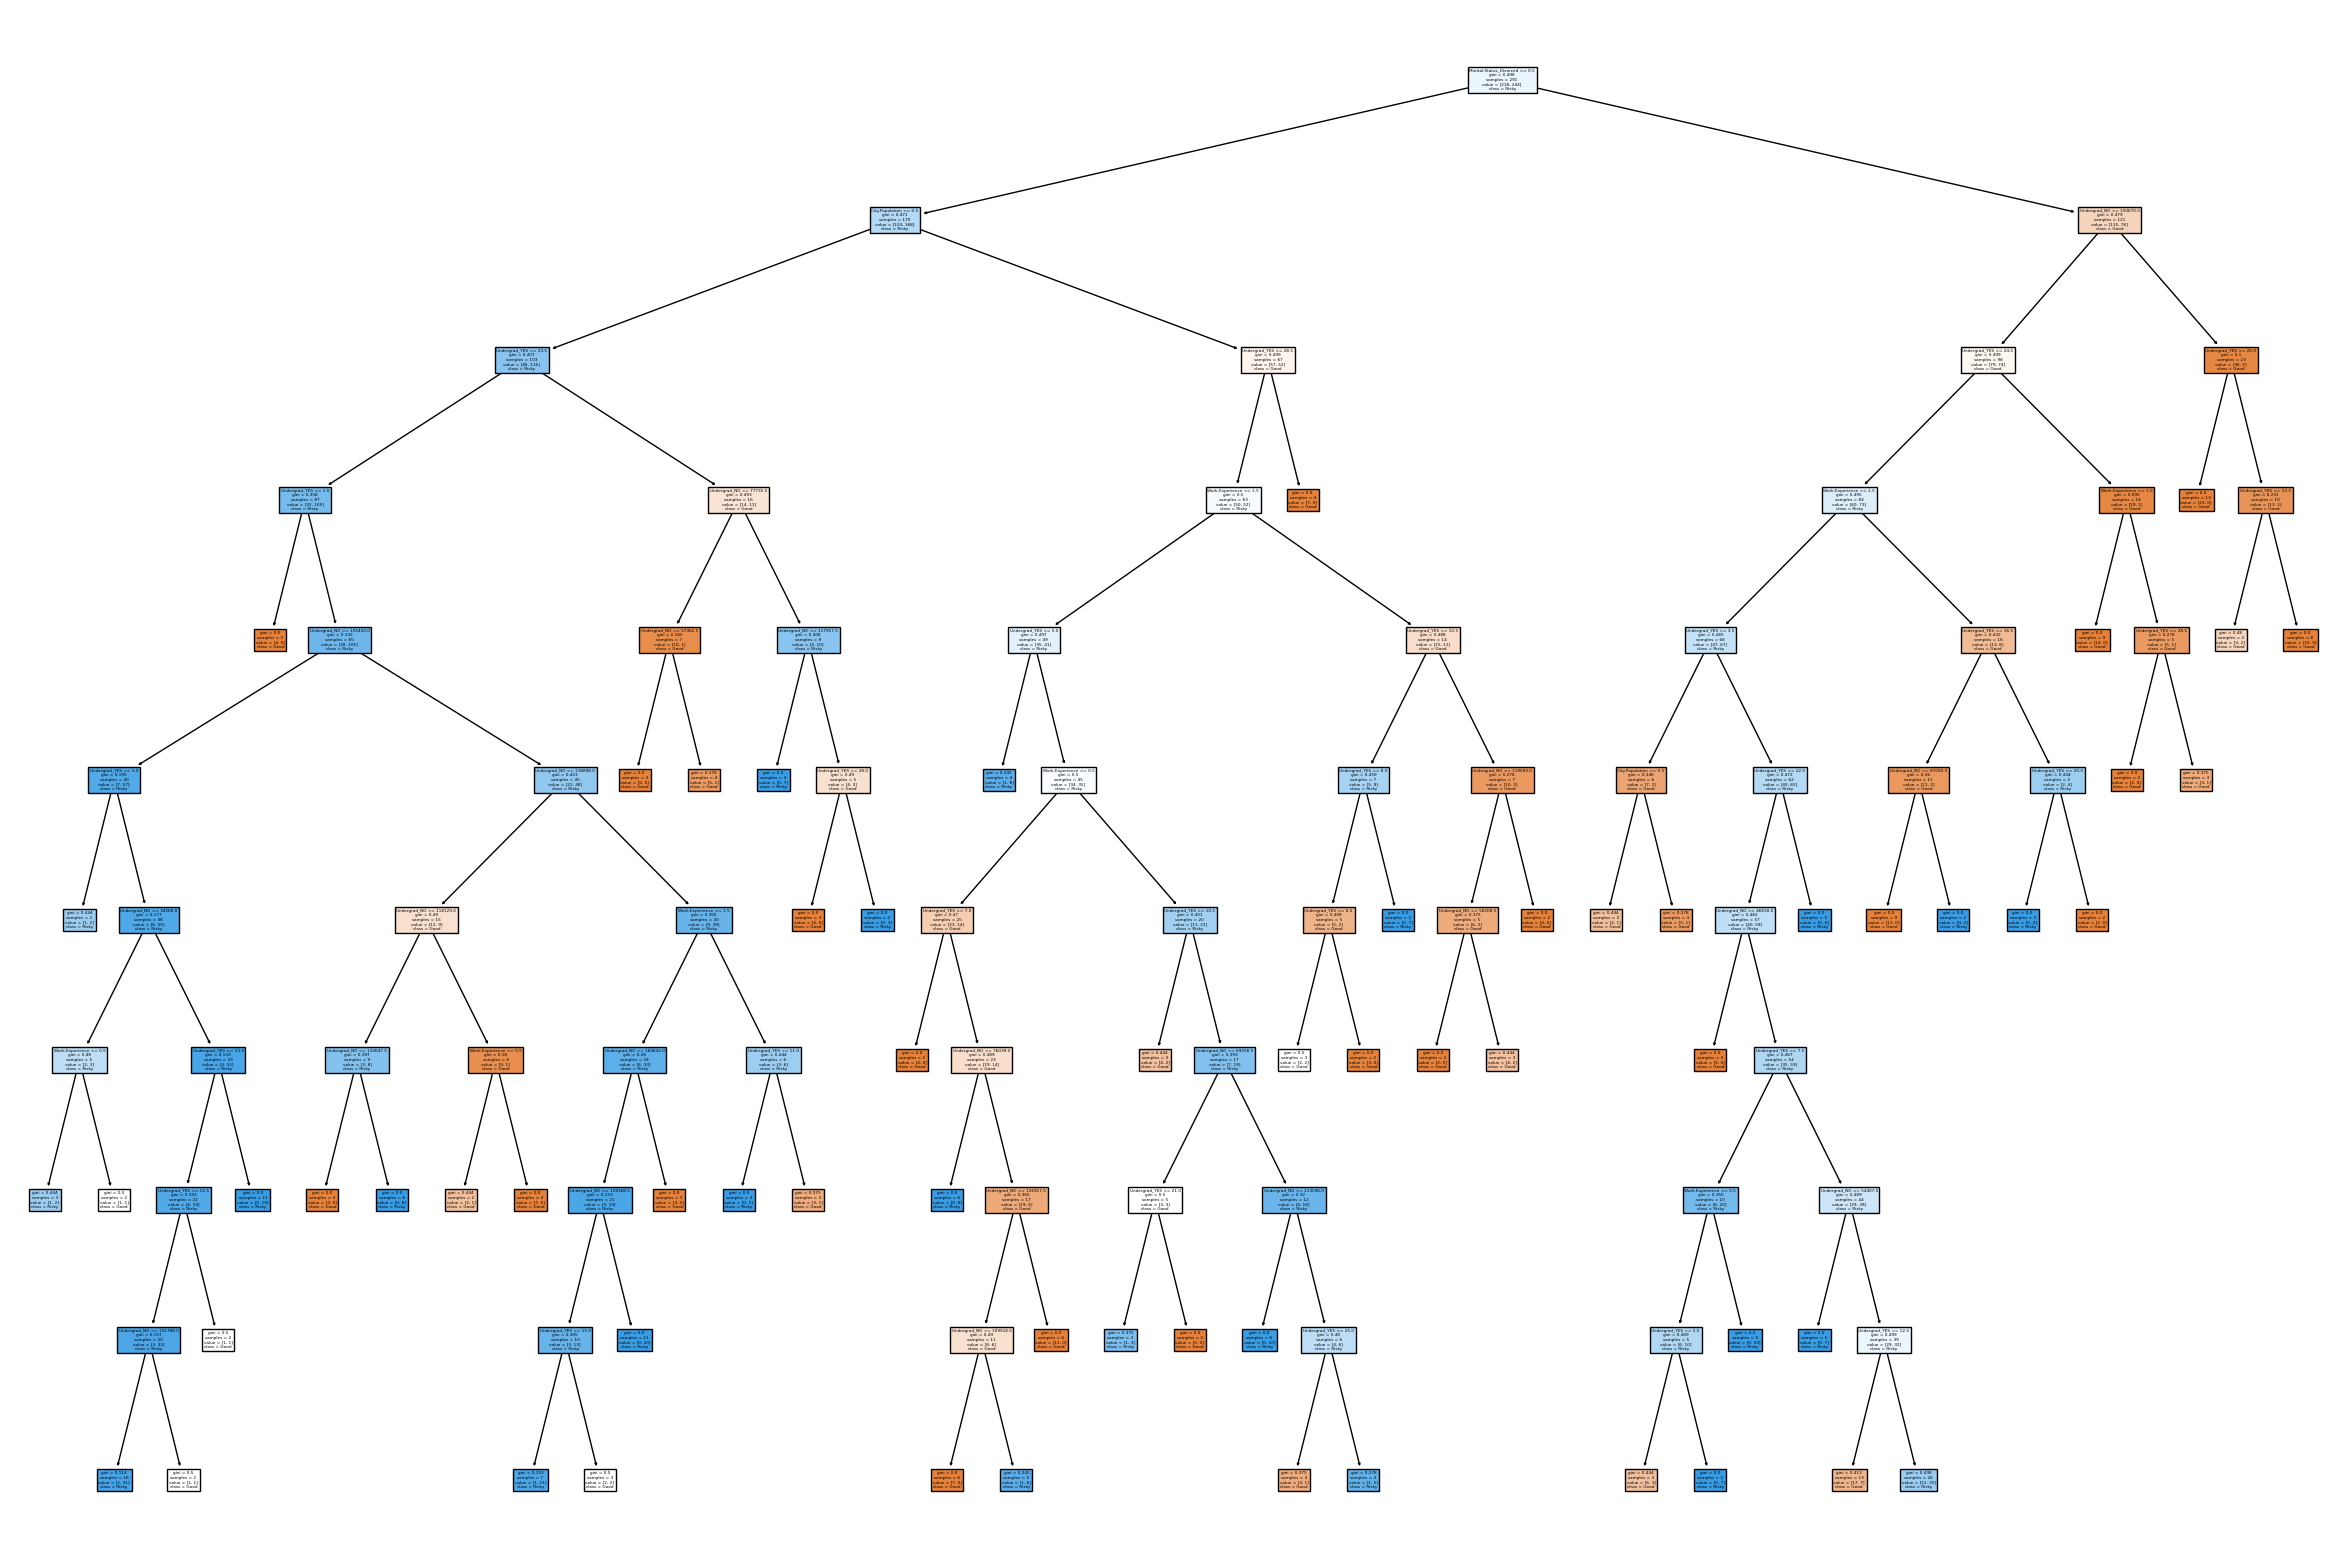

In [87]:
plt.figure(figsize=(30,20))
plot_tree(rf_best.estimators_[59], feature_names = fraud4.columns,class_names=fraud1['Taxable.Category'].unique(),filled=True)
plt.show()
